In [1]:
#[Joe] 1. Acquire and process stock data
#[Alejandra]x 2. Acquire and process sentiment analysis data
#[Session] 3. Run baseline
#[Joe]x 4. Run sentiment analysis with LinearDiscreminateAnalysis
#[Edward] 5. Run sentiment analysis with alternate classifier
#[Edward] 6. Combine results
#[Session] 7. Put together PPT preso

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from textblob import TextBlob
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import yfinance as yf
import warnings
from pandas.tseries.offsets import DateOffset
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# Ignore all warnings within this code block
warnings.filterwarnings("ignore")

In [2]:
## Acquire and process sentiment data from Kaggle
sentiment_df=pd.read_csv(Path("../Resources/combined_csv.csv"))
sentiment_df.head()

,Time,Headline,SP500 Close,Volume,TSLA Close,Volume.1
0,2017-12-18,Brace yourself for the next Brexit faultline: ...,268.200012,83653600.0,22.591333,82143000.0
1,2017-12-19,"First pilots, now cabin crew – Ryanair to reco...",267.170013,82382900.0,22.073334,102375000.0
2,2017-12-20,"Nearly 45,000 UK retailers in financial distre...",267.029999,76751500.0,21.931999,89307000.0
3,2017-12-21,Last-minute Christmas shopping guide: there is...,267.579987,67032300.0,22.110666,65778000.0
4,2017-12-22,Cramer: Never buy a stock all at once — you'll...,267.510010,78720900.0,21.680000,63237000.0


In [3]:
# obtain polarity and subjectivity scores (potentially factor volume of information in the sentiment analysis)

# create a function to calculate the subjectivity
def calculate_subjectivity(headlines):
    return TextBlob(headlines).sentiment.subjectivity

# create a function to calculate the subjectivity
def calculate_polarity(headlines):
    return TextBlob(headlines).sentiment.polarity


In [4]:
# create two new columns "Subjectivity" and "Polarity"
sentiment_df["Subjectivity"] = sentiment_df["Headline"].apply(calculate_subjectivity)
sentiment_df["Polarity"] = sentiment_df["Headline"].apply(calculate_polarity)

In [5]:
# create function to get the sentiment scores 
def get_scores(headlines):
    get_score= SentimentIntensityAnalyzer()
    sentiment=get_score.polarity_scores(headlines)
    return sentiment

In [6]:
# get daily sentiment scores
compound = []
neg = []
pos = []
neu = []
score = 0

for x in range(0, len(sentiment_df["Headline"])):
    score = get_scores(sentiment_df["Headline"][x])
    compound.append(score["compound"])
    neg.append(score["neg"])
    neu.append(score["neu"])
    pos.append(score["pos"])
    

In [7]:
# Add Column with sentiment scores
sentiment_df["compound"]= compound
sentiment_df["neg"]= neg
sentiment_df["pos"]= pos
sentiment_df["neu"]= neu



# Assuming you have a DataFrame named 'sentiment_df'
sentiment_df.rename(columns={'Volume.1': 'Tvolume'}, inplace=True)

#Display Dataframe
sentiment_df


,Time,Headline,SP500 Close,Volume,TSLA Close,Tvolume,Subjectivity,Polarity,compound,neg,pos,neu
0,2017-12-18,Brace yourself for the next Brexit faultline: ...,268.200012,83653600.0,22.591333,82143000.0,0.349438,-0.000624,-0.9425,0.122,0.075,0.804
1,2017-12-19,"First pilots, now cabin crew – Ryanair to reco...",267.170013,82382900.0,22.073334,102375000.0,0.303711,-0.043869,-0.9760,0.127,0.027,0.846
2,2017-12-20,"Nearly 45,000 UK retailers in financial distre...",267.029999,76751500.0,21.931999,89307000.0,0.405042,-0.020270,-0.8761,0.104,0.077,0.818
3,2017-12-21,Last-minute Christmas shopping guide: there is...,267.579987,67032300.0,22.110666,65778000.0,0.522302,-0.036371,0.4404,0.094,0.113,0.793
4,2017-12-22,Cramer: Never buy a stock all at once — you'll...,267.510010,78720900.0,21.680000,63237000.0,0.429320,0.038917,-0.2362,0.096,0.108,0.797
...,...,...,...,...,...,...,...,...,...,...,...,...
642,2020-07-13,"Luckin Coffee ousts chairman Lu, names Guo as ...",314.839996,102997500.0,99.804001,584781000.0,0.414809,0.140556,0.9773,0.100,0.123,0.777
643,2020-07-14,"Google hit with 600,000 euro Belgian privacy f...",318.920013,93657000.0,101.120003,351271500.0,0.345320,0.057631,-0.9830,0.104,0.082,0.814
644,2020-07-15,Oil climbs 2% on U.S. stock draw but gains cap...,321.850006,87196500.0,103.067329,245517000.0,0.387709,0.012013,0.5514,0.127,0.128,0.745
645,2020-07-16,Morgan Stanley posts record profit on trading ...,320.790009,54622500.0,100.042664,214512000.0,0.393206,0.088800,-0.9979,0.141,0.088,0.771


In [8]:
# # Calculate daily returns 
sentiment_df["daily returns"]= sentiment_df["TSLA Close"].pct_change()
sentiment_df.drop(columns=["SP500 Close", "Volume"], inplace = True)
sentiment_df= sentiment_df.set_index("Time")
sentiment_df.index= pd.to_datetime(sentiment_df.index)

In [9]:
# Calculate daily returns 
# sentiment_df["daily returns"]= sentiment_df["SP500 Close"].pct_change()
# sentiment_df.drop(columns=["TSLA Close", "Tvolume"], inplace = True)
# sentiment_df= sentiment_df.set_index("Time")
# sentiment_df.index= pd.to_datetime(sentiment_df.index)

In [10]:
# create label column add 1 when daily returns is positive and 0 when it is negative
sentiment_df["label"]= 0
sentiment_df.loc[(sentiment_df["daily returns"]> 0), 'label'] = 1

# verify that label is int
sentiment_df["label"].dtype

dtype('int64')

In [11]:
# # calculate SMA short and SMA slow
sentiment_df["sma_short"]= sentiment_df.rolling(7)["TSLA Close"].mean()
sentiment_df["sma_long"]= sentiment_df.rolling(30)["TSLA Close"].mean()
sentiment_df.dropna(inplace=True)

In [12]:
# calculate SMA short and SMA slow
# sentiment_df["sma_short"]= sentiment_df.rolling(7)["SP500 Close"].mean()
# sentiment_df["sma_long"]= sentiment_df.rolling(30)["SP500 Close"].mean()
# sentiment_df.dropna(inplace=True)

In [13]:
# display dataframe
sentiment_df.columns

Index(['Headline', 'TSLA Close', 'Tvolume', 'Subjectivity', 'Polarity',
       'compound', 'neg', 'pos', 'neu', 'daily returns', 'label', 'sma_short',
       'sma_long'],
      dtype='object')

In [15]:
# create features variable with columns for X
#TSLA Version
features=['Tvolume', 'Subjectivity', 'Polarity',
       'compound', 'neg', 'pos', 'neu', 'sma_short',
       'sma_long']

X = sentiment_df[features].shift().dropna().copy()
X.tail()

#SP500 Version
# create features variable with columns for X
# features=['Volume', 'Subjectivity', 'Polarity',
#        'compound', 'neg', 'pos', 'neu', 'sma_short',
#        'sma_long']

# X = sentiment_df[features].shift().dropna().copy()
# X.tail()

,Tvolume,Subjectivity,Polarity,compound,neg,pos,neu,sma_short,sma_long
Time,,,,,,,,,
2020-07-13,350064000.0,0.368474,0.074615,-0.4037,0.100,0.103,0.797,89.471810,69.838823
2020-07-14,584781000.0,0.414809,0.140556,0.9773,0.100,0.123,0.777,93.066382,71.310067
2020-07-15,351271500.0,0.345320,0.057631,-0.9830,0.104,0.082,0.814,96.001050,72.684956
2020-07-16,245517000.0,0.387709,0.012013,0.5514,0.127,0.128,0.745,97.662287,74.161511
2020-07-17,214512000.0,0.393206,0.088800,-0.9979,0.141,0.088,0.771,98.717334,75.534134


In [16]:
y=(sentiment_df['daily returns']>0).astype(int)[1:]

In [17]:
# verify x and y are same length

display(len(X))
display(len(y))

617

617

In [18]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=3)

# Display the training end date
print(training_end)

# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.head()

# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
X_train.head()

2018-02-02 00:00:00
2018-05-02 00:00:00


,Tvolume,Subjectivity,Polarity,compound,neg,pos,neu,sma_short,sma_long
Time,,,,,,,,,
2018-02-02,62965500.0,0.374069,0.058918,-0.9927,0.186,0.114,0.700,23.098000,22.354667
2018-02-05,55572000.0,0.400000,-0.073333,-0.1901,0.058,0.075,0.867,23.077619,22.365511
2018-02-06,66961500.0,0.468833,0.014328,-0.8130,0.114,0.075,0.811,23.034667,22.370022
2018-02-07,76326000.0,0.371886,0.014133,-0.9798,0.127,0.080,0.793,22.950096,22.381111
2018-02-08,104538000.0,0.423801,-0.000789,-0.8934,0.095,0.052,0.853,22.906953,22.410756


In [19]:
## Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [20]:
## Use a classifier to predict future results

# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)

# Review the model's predicted values
svm_pred[:10]

# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)

# Print the classification report
print(svm_testing_report)


              precision    recall  f1-score   support

           0       0.50      0.28      0.36       268
           1       0.52      0.74      0.61       288

    accuracy                           0.52       556
   macro avg       0.51      0.51      0.48       556
weighted avg       0.51      0.52      0.49       556



<Axes: xlabel='Time'>

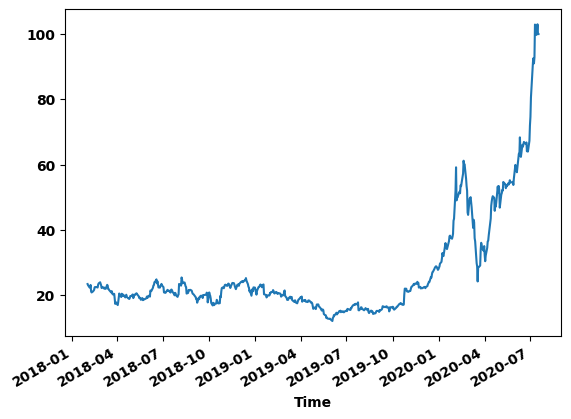

In [21]:
# plot TSLA close
sentiment_df["TSLA Close"].plot()

# plot SP500 close
# sentiment_df["SP500 Close"].plot()

In [22]:
y_test.value_counts()

daily returns
1    288
0    268
Name: count, dtype: int64

In [23]:
# Create a predictions DataFrame
predictions_sentiment_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_sentiment_df['Predicted'] = svm_pred

# Add the actual returns to the DataFrame
predictions_sentiment_df['Actual Returns'] = sentiment_df['daily returns'].pct_change()

# Add the strategy returns to the DataFrame
predictions_sentiment_df['Strategy Returns'] = predictions_sentiment_df['Actual Returns'] * predictions_sentiment_df['Predicted']

# Review the DataFrame
# display(predictions_sentiment_df.head())
# display(predictions_sentiment_df.tail())
predictions_sentiment_df

,Predicted,Actual Returns,Strategy Returns
Time,,,
2018-05-03,1,-14.521676,-14.521676
2018-05-04,1,-1.611136,-1.611136
2018-05-07,1,-0.129101,-0.129101
2018-05-08,1,-1.089527,-1.089527
2018-05-09,0,-7.115971,-0.000000
...,...,...,...
2020-07-13,1,-1.285677,-1.285677
2020-07-14,1,-1.427979,-1.427979
2020-07-15,1,0.460472,0.460472


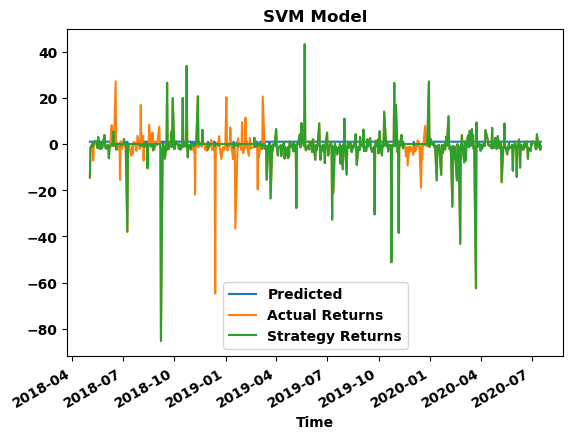

In [25]:
import matplotlib.pyplot as plt

predictions_sentiment_df.plot(title='SVM Model')

# Save the plot as a JPG file
plt.savefig('TSLA Close.jpg', format='jpg')

# Save the plot as a JPG file
# plt.savefig('SP500_SVM.jpg', format='jpg')


In [31]:
# instantiate LinearDiscriminantAnalysis
model = LinearDiscriminantAnalysis()

# fit the model
# model.fit(X_train_scaled, y_train)

In [32]:
# Fit the model to the data using the training data
linear_disc_model = model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
linear_disc_model = model.predict(X_test_scaled)

# Review the model's predicted values
linear_disc_model[:10]

# Use a classification report to evaluate the model using the predictions and testing data
linear_disc_testing_report = classification_report(y_test, linear_disc_model)

# Print the classification report
print(linear_disc_testing_report)


              precision    recall  f1-score   support

           0       0.48      0.50      0.49       268
           1       0.51      0.49      0.50       288

    accuracy                           0.49       556
   macro avg       0.49      0.49      0.49       556
weighted avg       0.50      0.49      0.49       556



In [29]:
predictions_sentiment_df_2 = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_sentiment_df_2['Predicted'] = linear_disc_model

# Add the actual returns to the DataFrame
predictions_sentiment_df_2['Actual Returns'] = sentiment_df['daily returns'].pct_change()

# Add the strategy returns to the DataFrame
predictions_sentiment_df_2['Strategy Returns'] = predictions_sentiment_df_2['Actual Returns'] * predictions_sentiment_df_2['Predicted']

# Review the DataFrame
# display(predictions_sentiment_df.head())
# display(predictions_sentiment_df.tail())
predictions_sentiment_df_2

,Predicted,Actual Returns,Strategy Returns
Time,,,
2018-05-03,0,-14.521676,-0.000000
2018-05-04,1,-1.611136,-1.611136
2018-05-07,1,-0.129101,-0.129101
2018-05-08,1,-1.089527,-1.089527
2018-05-09,1,-7.115971,-7.115971
...,...,...,...
2020-07-13,0,-1.285677,-0.000000
2020-07-14,0,-1.427979,-0.000000
2020-07-15,0,0.460472,0.000000


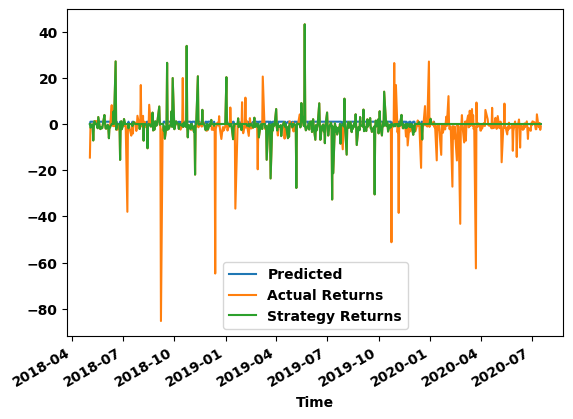

In [30]:
## Plot cummulative returns for the baseline model

# Plot the actual returns versus the strategy returns
# linear_disc_plot = (1 + predictions_sentiment_df_2[["Actual Returns", "Strategy Returns"]]).cumprod().plot()
# # Set the limits for the y-axis to zoom in
# linear_disc_plot.set_ylim(-50000, 50000)

predictions_sentiment_df_2.plot()
# plt.savefig('SP500 LinearDiscriminantAnalysis.jpg', format='jpg')
plt.savefig('TSLA LinearDiscriminantAnalysis.jpg', format='jpg')
